In [1]:
# * * * * * * * * * * * * * * * *
# Configuration
# * * * * * * * * * * * * * * * *
EXPERIMENT_NUM='4'

DATASET_DIR = '/workspace/datasets'
OUTPUT_DIR = '/workspace/outputs'

TARGET_METRIC='min_temp'
SAMPLE_SIZE=10000

DEVICE = "cpu"

LATENT_DIM=4
BATCH_SIZE=200
EPOCHS=100
BETA=0.2
LEARNING_RATE=1e-3
GAMMA=0.1

INPUT_DIM=(1,120)

In [2]:
import os
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torchinfo import summary

from lunar_vae import VAE, train, SampleLatentSpace, VisualizeLatentSpace
from utils import (
    CollectStatisticsFromProfilesV2,
    ConvertProfileListToCsv,
    CreateProfileSubset,
    GenerateDensityPlot,
    GetDataMetrics,
    GetMeanLatentValues,
    LoadProfileList,
    LoadTemperatureDataV2,
    PlotHistograms,
    PlotComparativeHistograms,
    PlotLosses,
    PrintAndLog,
    SaveLossesToCSV,
    SetupOutputDir,
    SplitAndNormalizeData,
)

# * * * * * * * * * * * * * * * *
# Setting Variables
# * * * * * * * * * * * * * * * *
PROFILES_DIR = os.path.join(DATASET_DIR, f'profiles-v2', f'profiles-v2-jsons')
ORIGINAL_PROFILE_LIST_JSON = os.path.join(DATASET_DIR, f'profiles-v2', f'profile_list_v2.json')
LABEL = f'profiles_v2_experiment_{EXPERIMENT_NUM}'
BINNED_PROFILE_LIST = os.path.join(DATASET_DIR, 'profiles-v2', 'profile_list_v2_binned.json')

# * * * * * * * * * * * * * * * *
# Make Directory
# * * * * * * * * * * * * * * * *
model_dir = SetupOutputDir(OUTPUT_DIR, parent_folder=LABEL, sub_folders=["reconstruction_images"])
print(f"Created directory {model_dir}")

Created directory /workspace/outputs/profiles_v2_experiment_4_20250329_2304


In [3]:
# * * * * * * * * * * * * * * * *
# Create Subset by Metric
# * * * * * * * * * * * * * * * *
SUBSET_PROFILE_LIST = os.path.join(model_dir, f'profile_list_v2_{TARGET_METRIC}_{SAMPLE_SIZE}.json')
CreateProfileSubset(BINNED_PROFILE_LIST, SUBSET_PROFILE_LIST, TARGET_METRIC, SAMPLE_SIZE)

In [4]:
# * * * * * * * * * * * * * * * *
# Load Profile List
# * * * * * * * * * * * * * * * *
profile_list = LoadProfileList(SUBSET_PROFILE_LIST)

In [5]:
# * * * * * * * * * * * * * * * *
# Convert to CSV
# * * * * * * * * * * * * * * * *
csv_path = ConvertProfileListToCsv(PROFILES_DIR, profile_list, model_dir)

Processing Profiles: 100%|██████████| 294386/294386 [01:42<00:00, 2858.99it/s]

Saved 294386 profiles to /workspace/outputs/profiles_v2_experiment_4_20250329_2304/20250329-dataset.csv


In [6]:
# * * * * * * * * * * * * * * * *
# Load Temp Data
# * * * * * * * * * * * * * * * *
temp_data = LoadTemperatureDataV2(csv_path, DEVICE)

Loading Profiles: 294386it [00:15, 18639.55it/s]


Saved figure to /workspace/outputs/profiles_v2_experiment_4_20250329_2304/density_plot.png


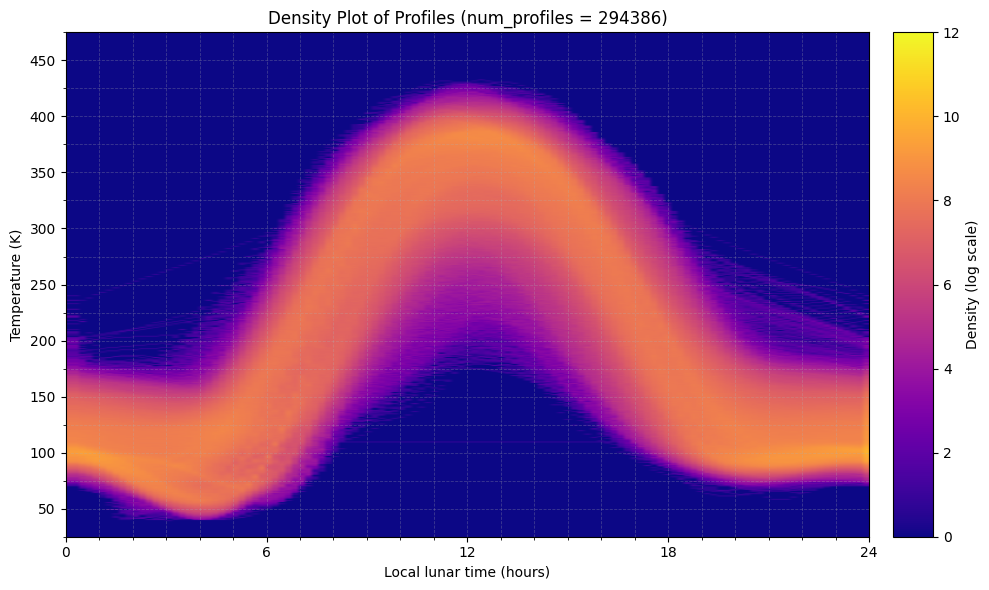

In [7]:
# * * * * * * * * * * * * * * * *
# Generate Density Plot
# * * * * * * * * * * * * * * * *
GenerateDensityPlot(temp_data, model_dir)

In [8]:
# * * * * * * * * * * * * * * * *
# Load Original Profile List
# * * * * * * * * * * * * * * * *
original_profile_list = LoadProfileList(ORIGINAL_PROFILE_LIST_JSON)

Saved figure to /workspace/outputs/profiles_v2_experiment_4_20250329_2304/histogram_max_temp.png


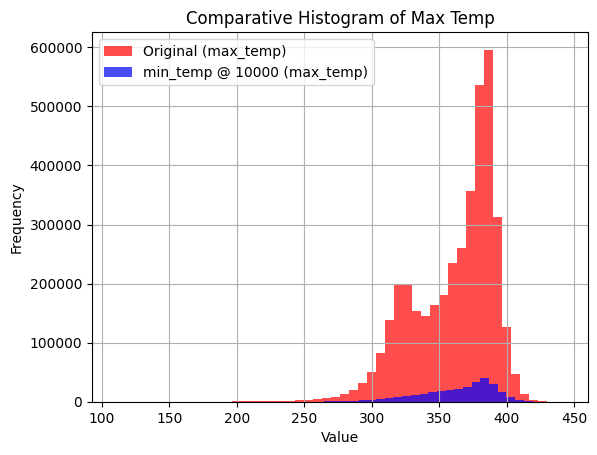

Saved figure to /workspace/outputs/profiles_v2_experiment_4_20250329_2304/histogram_min_temp.png


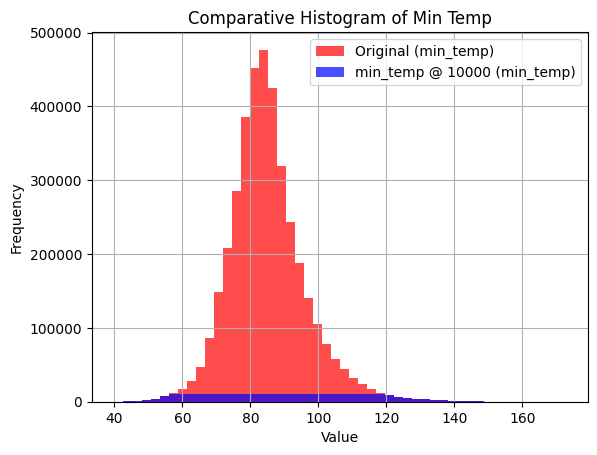

Saved figure to /workspace/outputs/profiles_v2_experiment_4_20250329_2304/histogram_mean_temp.png


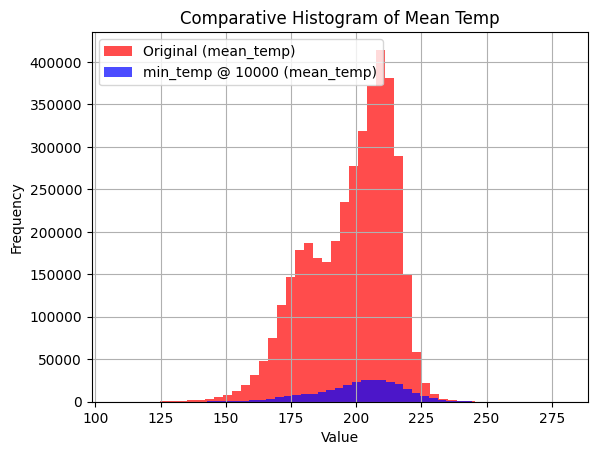

Saved figure to /workspace/outputs/profiles_v2_experiment_4_20250329_2304/histogram_std_temp.png


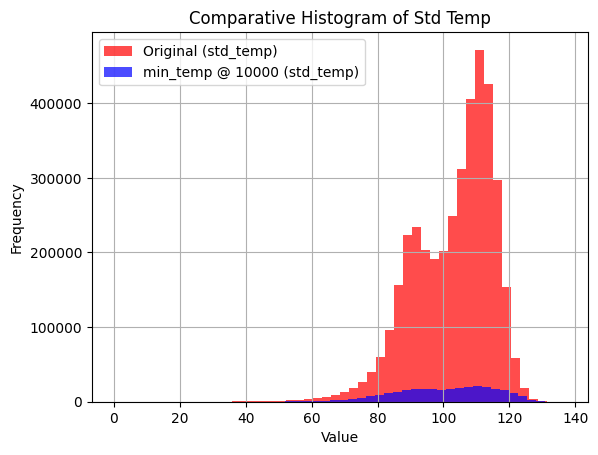

In [9]:
# * * * * * * * * * * * * * * * *
# Generate Histograms
# * * * * * * * * * * * * * * * *
statistics_original = CollectStatisticsFromProfilesV2(PROFILES_DIR, original_profile_list)
statistics_subset = CollectStatisticsFromProfilesV2(PROFILES_DIR, profile_list)
PlotComparativeHistograms(statistics_original, statistics_subset, labels=("Original", f"{TARGET_METRIC} @ {SAMPLE_SIZE}"), output_dir=model_dir)

In [10]:
# * * * * * * * * * * * * * * * *
# Training Log
# * * * * * * * * * * * * * * * 
log_filepath = os.path.join(model_dir, 'training.log')

# * * * * * * * * * * * * * * * *
# Data Prep
# * * * * * * * * * * * * * * * *
x_data_mean, x_data_std, x_data_min, x_data_max = GetDataMetrics(temp_data)

PrintAndLog(log_filepath, "Data Metrics:\n")
PrintAndLog(log_filepath, f"\tMean: {x_data_mean:.4f}\n")
PrintAndLog(log_filepath, f"\tSTD: {x_data_std:.4f}\n")
PrintAndLog(log_filepath, f"\tMin Temp: {x_data_min:.4f}\n")
PrintAndLog(log_filepath, f"\tMax Temp: {x_data_max:.4f}\n")

# Normalize Data (Mean=0, STD=1)
scaler = StandardScaler()
train_loader, val_loader, test_loader = SplitAndNormalizeData(
	temp_data, scaler, BATCH_SIZE, DEVICE)

PrintAndLog(log_filepath, "Datasets:\n")
PrintAndLog(
	log_filepath,
	f"\tTraining Data: {len(train_loader.dataset)}\n")
PrintAndLog(
	log_filepath,
	f"\tValidation Data: {len(val_loader.dataset)}\n")
PrintAndLog(log_filepath, f"\tTest Data: {len(test_loader.dataset)}\n")

Data Metrics:
Mean: 201.3282
STD: 102.1110
Min Temp: 40.0240
Max Temp: 432.0250
Datasets:
Training Data: 206070
Validation Data: 58877
Test Data: 29439


In [11]:
# * * * * * * * * * * * * * * * *
# VAE Setup
# * * * * * * * * * * * * * * * *
vae = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=GAMMA)

summary(vae, input_size=(BATCH_SIZE, INPUT_DIM[0], INPUT_DIM[1]))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [200, 1, 120]             --
├─Encoder: 1-1                           [200, 4, 1]               --
│    └─Wrap1d: 2-1                       [200, 1, 122]             --
│    └─ConstantPad1d: 2-2                [200, 1, 128]             --
│    └─Conv1d: 2-3                       [200, 32, 128]            128
│    └─BatchNorm1d: 2-4                  [200, 32, 128]            64
│    └─Conv1d: 2-5                       [200, 32, 64]             2,080
│    └─BatchNorm1d: 2-6                  [200, 32, 64]             64
│    └─Conv1d: 2-7                       [200, 32, 32]             2,080
│    └─BatchNorm1d: 2-8                  [200, 32, 32]             64
│    └─Conv1d: 2-9                       [200, 32, 16]             2,080
│    └─BatchNorm1d: 2-10                 [200, 32, 16]             64
│    └─Conv1d: 2-11                      [200, 32, 8]              2,080
│ 

In [12]:
# * * * * * * * * * * * * * * * *
# Train and Validate
# * * * * * * * * * * * * * * * *
losses = train(
	vae, train_loader, val_loader,
	optimizer, scheduler, DEVICE, EPOCHS,
	BETA, model_dir)

[Training] Epoch 1/100: 100%|██████████| 1031/1031 [00:35<00:00, 29.29it/s, best_loss=0.8236]


[Training] Epoch 1/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0012, LR: 0.001000


[Validation] Epoch 1/100: 100%|██████████| 295/295 [00:02<00:00, 100.98it/s]


[Validation] Epoch 1/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v2_experiment_4_20250329_2304'


[Training] Epoch 2/100: 100%|██████████| 1031/1031 [00:34<00:00, 30.10it/s, best_loss=0.8357]


[Training] Epoch 2/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000100


[Validation] Epoch 2/100: 100%|██████████| 295/295 [00:02<00:00, 105.12it/s]


[Validation] Epoch 2/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 3/100: 100%|██████████| 1031/1031 [00:34<00:00, 29.61it/s, best_loss=0.8652]


[Training] Epoch 3/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000010


[Validation] Epoch 3/100: 100%|██████████| 295/295 [00:02<00:00, 106.40it/s]


[Validation] Epoch 3/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 4/100: 100%|██████████| 1031/1031 [00:34<00:00, 29.62it/s, best_loss=0.8331]


[Training] Epoch 4/100, L1 Loss: 0.8152, L2 Loss: 1.0001, KL Loss: 0.0000, LR: 0.000001


[Validation] Epoch 4/100: 100%|██████████| 295/295 [00:02<00:00, 99.85it/s] 


[Validation] Epoch 4/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 5/100: 100%|██████████| 1031/1031 [00:34<00:00, 30.11it/s, best_loss=0.8268]


[Training] Epoch 5/100, L1 Loss: 0.8152, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 5/100: 100%|██████████| 295/295 [00:02<00:00, 108.71it/s]


[Validation] Epoch 5/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 6/100: 100%|██████████| 1031/1031 [00:34<00:00, 29.88it/s, best_loss=0.8273]


[Training] Epoch 6/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 6/100: 100%|██████████| 295/295 [00:02<00:00, 105.90it/s]


[Validation] Epoch 6/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 7/100: 100%|██████████| 1031/1031 [00:34<00:00, 30.30it/s, best_loss=0.8551]


[Training] Epoch 7/100, L1 Loss: 0.8151, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 7/100: 100%|██████████| 295/295 [00:02<00:00, 108.14it/s]


[Validation] Epoch 7/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 8/100: 100%|██████████| 1031/1031 [00:34<00:00, 30.21it/s, best_loss=0.8426]


[Training] Epoch 8/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 8/100: 100%|██████████| 295/295 [00:02<00:00, 100.68it/s]


[Validation] Epoch 8/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 9/100: 100%|██████████| 1031/1031 [00:34<00:00, 30.25it/s, best_loss=0.8437]


[Training] Epoch 9/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 9/100: 100%|██████████| 295/295 [00:02<00:00, 104.86it/s]


[Validation] Epoch 9/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 10/100: 100%|██████████| 1031/1031 [00:34<00:00, 30.30it/s, best_loss=0.8253]


[Training] Epoch 10/100, L1 Loss: 0.8152, L2 Loss: 1.0001, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 10/100: 100%|██████████| 295/295 [00:02<00:00, 110.44it/s]


[Validation] Epoch 10/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 11/100: 100%|██████████| 1031/1031 [00:33<00:00, 30.45it/s, best_loss=0.8405]


[Training] Epoch 11/100, L1 Loss: 0.8152, L2 Loss: 1.0001, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 11/100: 100%|██████████| 295/295 [00:02<00:00, 105.37it/s]


[Validation] Epoch 11/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 12/100: 100%|██████████| 1031/1031 [00:33<00:00, 30.35it/s, best_loss=0.8533]


[Training] Epoch 12/100, L1 Loss: 0.8152, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 12/100: 100%|██████████| 295/295 [00:02<00:00, 108.18it/s]


[Validation] Epoch 12/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 13/100: 100%|██████████| 1031/1031 [00:33<00:00, 30.65it/s, best_loss=0.8513]


[Training] Epoch 13/100, L1 Loss: 0.8152, L2 Loss: 1.0001, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 13/100: 100%|██████████| 295/295 [00:02<00:00, 110.38it/s]


[Validation] Epoch 13/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 14/100: 100%|██████████| 1031/1031 [00:33<00:00, 31.00it/s, best_loss=0.8473]


[Training] Epoch 14/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 14/100: 100%|██████████| 295/295 [00:02<00:00, 103.35it/s]


[Validation] Epoch 14/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 15/100: 100%|██████████| 1031/1031 [00:34<00:00, 29.84it/s, best_loss=0.8425]


[Training] Epoch 15/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 15/100: 100%|██████████| 295/295 [00:02<00:00, 103.05it/s]


[Validation] Epoch 15/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 16/100: 100%|██████████| 1031/1031 [00:34<00:00, 30.30it/s, best_loss=0.8489]


[Training] Epoch 16/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 16/100: 100%|██████████| 295/295 [00:02<00:00, 111.62it/s]


[Validation] Epoch 16/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 17/100: 100%|██████████| 1031/1031 [00:33<00:00, 30.59it/s, best_loss=0.8524]


[Training] Epoch 17/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 17/100: 100%|██████████| 295/295 [00:02<00:00, 107.54it/s]


[Validation] Epoch 17/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 18/100: 100%|██████████| 1031/1031 [00:33<00:00, 30.46it/s, best_loss=0.8352]


[Training] Epoch 18/100, L1 Loss: 0.8152, L2 Loss: 1.0001, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 18/100: 100%|██████████| 295/295 [00:02<00:00, 108.84it/s]


[Validation] Epoch 18/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 19/100: 100%|██████████| 1031/1031 [00:33<00:00, 30.65it/s, best_loss=0.8347]


[Training] Epoch 19/100, L1 Loss: 0.8152, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 19/100: 100%|██████████| 295/295 [00:02<00:00, 113.45it/s]


[Validation] Epoch 19/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 20/100: 100%|██████████| 1031/1031 [00:33<00:00, 30.42it/s, best_loss=0.8481]


[Training] Epoch 20/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 20/100: 100%|██████████| 295/295 [00:02<00:00, 108.43it/s]


[Validation] Epoch 20/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 21/100: 100%|██████████| 1031/1031 [00:33<00:00, 30.65it/s, best_loss=0.8662]


[Training] Epoch 21/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 21/100: 100%|██████████| 295/295 [00:02<00:00, 105.60it/s]


[Validation] Epoch 21/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 22/100: 100%|██████████| 1031/1031 [00:33<00:00, 31.01it/s, best_loss=0.8195]


[Training] Epoch 22/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 22/100: 100%|██████████| 295/295 [00:02<00:00, 105.89it/s]


[Validation] Epoch 22/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 23/100: 100%|██████████| 1031/1031 [00:33<00:00, 30.54it/s, best_loss=0.8512]


[Training] Epoch 23/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 23/100: 100%|██████████| 295/295 [00:02<00:00, 110.10it/s]


[Validation] Epoch 23/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 24/100: 100%|██████████| 1031/1031 [00:33<00:00, 30.41it/s, best_loss=0.8363]


[Training] Epoch 24/100, L1 Loss: 0.8152, L2 Loss: 1.0001, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 24/100: 100%|██████████| 295/295 [00:02<00:00, 105.98it/s]


[Validation] Epoch 24/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 25/100: 100%|██████████| 1031/1031 [00:33<00:00, 30.81it/s, best_loss=0.8252]


[Training] Epoch 25/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 25/100: 100%|██████████| 295/295 [00:02<00:00, 108.24it/s]


[Validation] Epoch 25/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 26/100: 100%|██████████| 1031/1031 [00:33<00:00, 30.45it/s, best_loss=0.8566]


[Training] Epoch 26/100, L1 Loss: 0.8152, L2 Loss: 1.0001, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 26/100: 100%|██████████| 295/295 [00:02<00:00, 101.54it/s]


[Validation] Epoch 26/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 27/100: 100%|██████████| 1031/1031 [00:33<00:00, 30.41it/s, best_loss=0.8256]


[Training] Epoch 27/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 27/100: 100%|██████████| 295/295 [00:02<00:00, 107.51it/s]


[Validation] Epoch 27/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 28/100: 100%|██████████| 1031/1031 [00:33<00:00, 30.45it/s, best_loss=0.8488]


[Training] Epoch 28/100, L1 Loss: 0.8152, L2 Loss: 1.0001, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 28/100: 100%|██████████| 295/295 [00:02<00:00, 100.06it/s]


[Validation] Epoch 28/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 29/100: 100%|██████████| 1031/1031 [00:34<00:00, 30.18it/s, best_loss=0.8260]


[Training] Epoch 29/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 29/100: 100%|██████████| 295/295 [00:02<00:00, 102.80it/s]


[Validation] Epoch 29/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 30/100: 100%|██████████| 1031/1031 [00:34<00:00, 30.25it/s, best_loss=0.8462]


[Training] Epoch 30/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 30/100: 100%|██████████| 295/295 [00:02<00:00, 105.51it/s]


[Validation] Epoch 30/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 31/100: 100%|██████████| 1031/1031 [00:33<00:00, 30.36it/s, best_loss=0.8339]


[Training] Epoch 31/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 31/100: 100%|██████████| 295/295 [00:02<00:00, 103.08it/s]


[Validation] Epoch 31/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 32/100: 100%|██████████| 1031/1031 [00:34<00:00, 29.77it/s, best_loss=0.8456]


[Training] Epoch 32/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 32/100: 100%|██████████| 295/295 [00:02<00:00, 103.25it/s]


[Validation] Epoch 32/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 33/100: 100%|██████████| 1031/1031 [00:33<00:00, 30.46it/s, best_loss=0.8198]


[Training] Epoch 33/100, L1 Loss: 0.8151, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 33/100: 100%|██████████| 295/295 [00:02<00:00, 105.19it/s]


[Validation] Epoch 33/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 34/100: 100%|██████████| 1031/1031 [00:34<00:00, 30.01it/s, best_loss=0.8478]


[Training] Epoch 34/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 34/100: 100%|██████████| 295/295 [00:02<00:00, 111.78it/s]


[Validation] Epoch 34/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 35/100: 100%|██████████| 1031/1031 [00:34<00:00, 30.23it/s, best_loss=0.8537]


[Training] Epoch 35/100, L1 Loss: 0.8152, L2 Loss: 1.0001, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 35/100: 100%|██████████| 295/295 [00:02<00:00, 104.29it/s]


[Validation] Epoch 35/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 36/100: 100%|██████████| 1031/1031 [00:34<00:00, 29.88it/s, best_loss=0.8256]


[Training] Epoch 36/100, L1 Loss: 0.8152, L2 Loss: 1.0001, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 36/100: 100%|██████████| 295/295 [00:02<00:00, 107.82it/s]


[Validation] Epoch 36/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 37/100: 100%|██████████| 1031/1031 [00:34<00:00, 29.83it/s, best_loss=0.8159]


[Training] Epoch 37/100, L1 Loss: 0.8151, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 37/100: 100%|██████████| 295/295 [00:02<00:00, 106.08it/s]


[Validation] Epoch 37/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 38/100: 100%|██████████| 1031/1031 [00:34<00:00, 29.89it/s, best_loss=0.8511]


[Training] Epoch 38/100, L1 Loss: 0.8151, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 38/100: 100%|██████████| 295/295 [00:02<00:00, 100.96it/s]


[Validation] Epoch 38/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 39/100: 100%|██████████| 1031/1031 [00:33<00:00, 30.39it/s, best_loss=0.8594]


[Training] Epoch 39/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 39/100: 100%|██████████| 295/295 [00:03<00:00, 97.60it/s] 


[Validation] Epoch 39/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 40/100: 100%|██████████| 1031/1031 [00:34<00:00, 29.64it/s, best_loss=0.8527]


[Training] Epoch 40/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 40/100: 100%|██████████| 295/295 [00:02<00:00, 101.33it/s]


[Validation] Epoch 40/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 41/100: 100%|██████████| 1031/1031 [00:34<00:00, 30.07it/s, best_loss=0.8552]


[Training] Epoch 41/100, L1 Loss: 0.8151, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 41/100: 100%|██████████| 295/295 [00:02<00:00, 103.13it/s]


[Validation] Epoch 41/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 42/100: 100%|██████████| 1031/1031 [00:34<00:00, 30.19it/s, best_loss=0.8587]


[Training] Epoch 42/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 42/100: 100%|██████████| 295/295 [00:02<00:00, 108.94it/s]


[Validation] Epoch 42/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 43/100: 100%|██████████| 1031/1031 [00:34<00:00, 30.17it/s, best_loss=0.8590]


[Training] Epoch 43/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 43/100: 100%|██████████| 295/295 [00:02<00:00, 103.94it/s]


[Validation] Epoch 43/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 44/100: 100%|██████████| 1031/1031 [00:33<00:00, 30.56it/s, best_loss=0.8459]


[Training] Epoch 44/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 44/100: 100%|██████████| 295/295 [00:02<00:00, 110.38it/s]


[Validation] Epoch 44/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 45/100: 100%|██████████| 1031/1031 [00:33<00:00, 30.36it/s, best_loss=0.8436]


[Training] Epoch 45/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 45/100: 100%|██████████| 295/295 [00:02<00:00, 104.99it/s]


[Validation] Epoch 45/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 46/100: 100%|██████████| 1031/1031 [00:33<00:00, 30.48it/s, best_loss=0.8435]


[Training] Epoch 46/100, L1 Loss: 0.8151, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 46/100: 100%|██████████| 295/295 [00:02<00:00, 105.47it/s]


[Validation] Epoch 46/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 47/100: 100%|██████████| 1031/1031 [00:33<00:00, 30.35it/s, best_loss=0.8516]


[Training] Epoch 47/100, L1 Loss: 0.8152, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 47/100: 100%|██████████| 295/295 [00:02<00:00, 105.99it/s]


[Validation] Epoch 47/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 48/100: 100%|██████████| 1031/1031 [00:34<00:00, 29.71it/s, best_loss=0.8359]


[Training] Epoch 48/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 48/100: 100%|██████████| 295/295 [00:02<00:00, 107.73it/s]


[Validation] Epoch 48/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 49/100: 100%|██████████| 1031/1031 [00:33<00:00, 30.81it/s, best_loss=0.8573]


[Training] Epoch 49/100, L1 Loss: 0.8152, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 49/100: 100%|██████████| 295/295 [00:02<00:00, 109.17it/s]


[Validation] Epoch 49/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 50/100: 100%|██████████| 1031/1031 [00:33<00:00, 30.48it/s, best_loss=0.8211]


[Training] Epoch 50/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 50/100: 100%|██████████| 295/295 [00:02<00:00, 104.06it/s]


[Validation] Epoch 50/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 51/100: 100%|██████████| 1031/1031 [00:33<00:00, 30.45it/s, best_loss=0.8492]


[Training] Epoch 51/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 51/100: 100%|██████████| 295/295 [00:02<00:00, 109.04it/s]


[Validation] Epoch 51/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 52/100: 100%|██████████| 1031/1031 [00:34<00:00, 30.12it/s, best_loss=0.8463]


[Training] Epoch 52/100, L1 Loss: 0.8152, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 52/100: 100%|██████████| 295/295 [00:02<00:00, 103.56it/s]


[Validation] Epoch 52/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 53/100: 100%|██████████| 1031/1031 [00:33<00:00, 30.41it/s, best_loss=0.8088]


[Training] Epoch 53/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 53/100: 100%|██████████| 295/295 [00:02<00:00, 105.38it/s]


[Validation] Epoch 53/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 54/100: 100%|██████████| 1031/1031 [00:34<00:00, 29.77it/s, best_loss=0.7808]


[Training] Epoch 54/100, L1 Loss: 0.8152, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 54/100: 100%|██████████| 295/295 [00:02<00:00, 107.04it/s]


[Validation] Epoch 54/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 55/100: 100%|██████████| 1031/1031 [00:34<00:00, 30.17it/s, best_loss=0.8478]


[Training] Epoch 55/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 55/100: 100%|██████████| 295/295 [00:02<00:00, 104.10it/s]


[Validation] Epoch 55/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 56/100: 100%|██████████| 1031/1031 [00:33<00:00, 30.60it/s, best_loss=0.8479]


[Training] Epoch 56/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 56/100: 100%|██████████| 295/295 [00:02<00:00, 109.67it/s]


[Validation] Epoch 56/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 57/100: 100%|██████████| 1031/1031 [00:34<00:00, 29.95it/s, best_loss=0.8452]


[Training] Epoch 57/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 57/100: 100%|██████████| 295/295 [00:02<00:00, 101.49it/s]


[Validation] Epoch 57/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 58/100: 100%|██████████| 1031/1031 [00:34<00:00, 30.16it/s, best_loss=0.8632]


[Training] Epoch 58/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 58/100: 100%|██████████| 295/295 [00:02<00:00, 100.18it/s]


[Validation] Epoch 58/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 59/100: 100%|██████████| 1031/1031 [00:33<00:00, 30.61it/s, best_loss=0.8583]


[Training] Epoch 59/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 59/100: 100%|██████████| 295/295 [00:02<00:00, 104.40it/s]


[Validation] Epoch 59/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 60/100: 100%|██████████| 1031/1031 [00:34<00:00, 29.86it/s, best_loss=0.8324]


[Training] Epoch 60/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 60/100: 100%|██████████| 295/295 [00:02<00:00, 106.95it/s]


[Validation] Epoch 60/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 61/100: 100%|██████████| 1031/1031 [00:33<00:00, 30.49it/s, best_loss=0.8509]


[Training] Epoch 61/100, L1 Loss: 0.8151, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 61/100: 100%|██████████| 295/295 [00:02<00:00, 108.11it/s]


[Validation] Epoch 61/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 62/100: 100%|██████████| 1031/1031 [00:33<00:00, 30.39it/s, best_loss=0.8336]


[Training] Epoch 62/100, L1 Loss: 0.8152, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 62/100: 100%|██████████| 295/295 [00:02<00:00, 105.99it/s]


[Validation] Epoch 62/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 63/100: 100%|██████████| 1031/1031 [00:33<00:00, 30.60it/s, best_loss=0.8539]


[Training] Epoch 63/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 63/100: 100%|██████████| 295/295 [00:02<00:00, 106.15it/s]


[Validation] Epoch 63/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 64/100: 100%|██████████| 1031/1031 [00:33<00:00, 31.06it/s, best_loss=0.8295]


[Training] Epoch 64/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 64/100: 100%|██████████| 295/295 [00:03<00:00, 96.14it/s] 


[Validation] Epoch 64/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 65/100: 100%|██████████| 1031/1031 [00:36<00:00, 28.22it/s, best_loss=0.8500]


[Training] Epoch 65/100, L1 Loss: 0.8152, L2 Loss: 1.0001, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 65/100: 100%|██████████| 295/295 [00:03<00:00, 92.52it/s] 


[Validation] Epoch 65/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 66/100: 100%|██████████| 1031/1031 [00:34<00:00, 29.49it/s, best_loss=0.8467]


[Training] Epoch 66/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 66/100: 100%|██████████| 295/295 [00:03<00:00, 88.27it/s] 


[Validation] Epoch 66/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 67/100: 100%|██████████| 1031/1031 [00:34<00:00, 29.98it/s, best_loss=0.8219]


[Training] Epoch 67/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 67/100: 100%|██████████| 295/295 [00:03<00:00, 91.14it/s] 


[Validation] Epoch 67/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 68/100: 100%|██████████| 1031/1031 [00:34<00:00, 29.53it/s, best_loss=0.8487]


[Training] Epoch 68/100, L1 Loss: 0.8152, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 68/100: 100%|██████████| 295/295 [00:03<00:00, 88.13it/s] 


[Validation] Epoch 68/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 69/100: 100%|██████████| 1031/1031 [00:34<00:00, 29.99it/s, best_loss=0.8245]


[Training] Epoch 69/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 69/100: 100%|██████████| 295/295 [00:03<00:00, 89.76it/s] 


[Validation] Epoch 69/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 70/100: 100%|██████████| 1031/1031 [00:34<00:00, 29.66it/s, best_loss=0.8389]


[Training] Epoch 70/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 70/100: 100%|██████████| 295/295 [00:03<00:00, 90.07it/s] 


[Validation] Epoch 70/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 71/100: 100%|██████████| 1031/1031 [00:34<00:00, 29.71it/s, best_loss=0.8026]


[Training] Epoch 71/100, L1 Loss: 0.8151, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 71/100: 100%|██████████| 295/295 [00:03<00:00, 89.81it/s] 


[Validation] Epoch 71/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 72/100: 100%|██████████| 1031/1031 [00:35<00:00, 28.78it/s, best_loss=0.8388]


[Training] Epoch 72/100, L1 Loss: 0.8151, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 72/100: 100%|██████████| 295/295 [00:03<00:00, 89.06it/s] 


[Validation] Epoch 72/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 73/100: 100%|██████████| 1031/1031 [00:35<00:00, 29.42it/s, best_loss=0.8499]


[Training] Epoch 73/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 73/100: 100%|██████████| 295/295 [00:03<00:00, 95.33it/s] 


[Validation] Epoch 73/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 74/100: 100%|██████████| 1031/1031 [00:34<00:00, 29.83it/s, best_loss=0.8379]


[Training] Epoch 74/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 74/100: 100%|██████████| 295/295 [00:03<00:00, 92.32it/s] 


[Validation] Epoch 74/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 75/100: 100%|██████████| 1031/1031 [00:34<00:00, 29.73it/s, best_loss=0.8233]


[Training] Epoch 75/100, L1 Loss: 0.8151, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 75/100: 100%|██████████| 295/295 [00:03<00:00, 87.77it/s] 


[Validation] Epoch 75/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 76/100: 100%|██████████| 1031/1031 [00:35<00:00, 29.45it/s, best_loss=0.8616]


[Training] Epoch 76/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 76/100: 100%|██████████| 295/295 [00:03<00:00, 91.64it/s] 


[Validation] Epoch 76/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 77/100: 100%|██████████| 1031/1031 [00:35<00:00, 29.32it/s, best_loss=0.7918]


[Training] Epoch 77/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 77/100: 100%|██████████| 295/295 [00:03<00:00, 89.70it/s] 


[Validation] Epoch 77/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 78/100: 100%|██████████| 1031/1031 [00:35<00:00, 29.42it/s, best_loss=0.8413]


[Training] Epoch 78/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 78/100: 100%|██████████| 295/295 [00:03<00:00, 87.18it/s] 


[Validation] Epoch 78/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 79/100: 100%|██████████| 1031/1031 [00:34<00:00, 29.90it/s, best_loss=0.8502]


[Training] Epoch 79/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 79/100: 100%|██████████| 295/295 [00:03<00:00, 90.39it/s] 


[Validation] Epoch 79/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 80/100: 100%|██████████| 1031/1031 [00:35<00:00, 28.79it/s, best_loss=0.8305]


[Training] Epoch 80/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 80/100: 100%|██████████| 295/295 [00:03<00:00, 82.79it/s]


[Validation] Epoch 80/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 81/100: 100%|██████████| 1031/1031 [00:35<00:00, 29.41it/s, best_loss=0.8623]


[Training] Epoch 81/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 81/100: 100%|██████████| 295/295 [00:03<00:00, 84.64it/s] 


[Validation] Epoch 81/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 82/100: 100%|██████████| 1031/1031 [00:35<00:00, 29.33it/s, best_loss=0.8411]


[Training] Epoch 82/100, L1 Loss: 0.8152, L2 Loss: 1.0001, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 82/100: 100%|██████████| 295/295 [00:03<00:00, 89.15it/s] 


[Validation] Epoch 82/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 83/100: 100%|██████████| 1031/1031 [00:35<00:00, 28.89it/s, best_loss=0.8453]


[Training] Epoch 83/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 83/100: 100%|██████████| 295/295 [00:02<00:00, 102.11it/s]


[Validation] Epoch 83/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 84/100: 100%|██████████| 1031/1031 [00:35<00:00, 29.18it/s, best_loss=0.8224]


[Training] Epoch 84/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 84/100: 100%|██████████| 295/295 [00:02<00:00, 101.95it/s]


[Validation] Epoch 84/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 85/100: 100%|██████████| 1031/1031 [00:35<00:00, 29.44it/s, best_loss=0.8474]


[Training] Epoch 85/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 85/100: 100%|██████████| 295/295 [00:02<00:00, 100.37it/s]


[Validation] Epoch 85/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 86/100: 100%|██████████| 1031/1031 [00:35<00:00, 29.21it/s, best_loss=0.8419]


[Training] Epoch 86/100, L1 Loss: 0.8152, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 86/100: 100%|██████████| 295/295 [00:02<00:00, 100.81it/s]


[Validation] Epoch 86/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 87/100: 100%|██████████| 1031/1031 [00:35<00:00, 29.42it/s, best_loss=0.8508]


[Training] Epoch 87/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 87/100: 100%|██████████| 295/295 [00:02<00:00, 100.27it/s]


[Validation] Epoch 87/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 88/100: 100%|██████████| 1031/1031 [00:35<00:00, 29.04it/s, best_loss=0.8467]


[Training] Epoch 88/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 88/100: 100%|██████████| 295/295 [00:02<00:00, 99.64it/s] 


[Validation] Epoch 88/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 89/100: 100%|██████████| 1031/1031 [00:35<00:00, 29.40it/s, best_loss=0.8569]


[Training] Epoch 89/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 89/100: 100%|██████████| 295/295 [00:02<00:00, 100.43it/s]


[Validation] Epoch 89/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 90/100: 100%|██████████| 1031/1031 [00:35<00:00, 29.40it/s, best_loss=0.8537]


[Training] Epoch 90/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 90/100: 100%|██████████| 295/295 [00:02<00:00, 100.60it/s]


[Validation] Epoch 90/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 91/100: 100%|██████████| 1031/1031 [00:35<00:00, 29.30it/s, best_loss=0.8199]


[Training] Epoch 91/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 91/100: 100%|██████████| 295/295 [00:02<00:00, 102.30it/s]


[Validation] Epoch 91/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 92/100: 100%|██████████| 1031/1031 [00:35<00:00, 29.15it/s, best_loss=0.8682]


[Training] Epoch 92/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 92/100: 100%|██████████| 295/295 [00:02<00:00, 100.34it/s]


[Validation] Epoch 92/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 93/100: 100%|██████████| 1031/1031 [00:35<00:00, 29.24it/s, best_loss=0.8312]


[Training] Epoch 93/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 93/100: 100%|██████████| 295/295 [00:02<00:00, 101.02it/s]


[Validation] Epoch 93/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 94/100: 100%|██████████| 1031/1031 [00:34<00:00, 29.55it/s, best_loss=0.8322]


[Training] Epoch 94/100, L1 Loss: 0.8152, L2 Loss: 1.0001, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 94/100: 100%|██████████| 295/295 [00:02<00:00, 101.91it/s]


[Validation] Epoch 94/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 95/100: 100%|██████████| 1031/1031 [00:35<00:00, 29.44it/s, best_loss=0.8387]


[Training] Epoch 95/100, L1 Loss: 0.8152, L2 Loss: 1.0001, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 95/100: 100%|██████████| 295/295 [00:02<00:00, 102.25it/s]


[Validation] Epoch 95/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 96/100: 100%|██████████| 1031/1031 [00:35<00:00, 28.98it/s, best_loss=0.8558]


[Training] Epoch 96/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 96/100: 100%|██████████| 295/295 [00:02<00:00, 100.34it/s]


[Validation] Epoch 96/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 97/100: 100%|██████████| 1031/1031 [00:35<00:00, 28.82it/s, best_loss=0.8391]


[Training] Epoch 97/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 97/100: 100%|██████████| 295/295 [00:02<00:00, 100.92it/s]


[Validation] Epoch 97/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 98/100: 100%|██████████| 1031/1031 [00:35<00:00, 28.76it/s, best_loss=0.8418]


[Training] Epoch 98/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 98/100: 100%|██████████| 295/295 [00:02<00:00, 100.22it/s]


[Validation] Epoch 98/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 99/100: 100%|██████████| 1031/1031 [00:35<00:00, 29.15it/s, best_loss=0.8582]


[Training] Epoch 99/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 99/100: 100%|██████████| 295/295 [00:02<00:00, 100.22it/s]


[Validation] Epoch 99/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


[Training] Epoch 100/100: 100%|██████████| 1031/1031 [00:35<00:00, 29.29it/s, best_loss=0.8555]


[Training] Epoch 100/100, L1 Loss: 0.8152, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 100/100: 100%|██████████| 295/295 [00:02<00:00, 99.35it/s] 

[Validation] Epoch 100/100, Val L1 Loss: 0.8145, Val L2 Loss: 0.9994, Val KL Loss: 0.0000


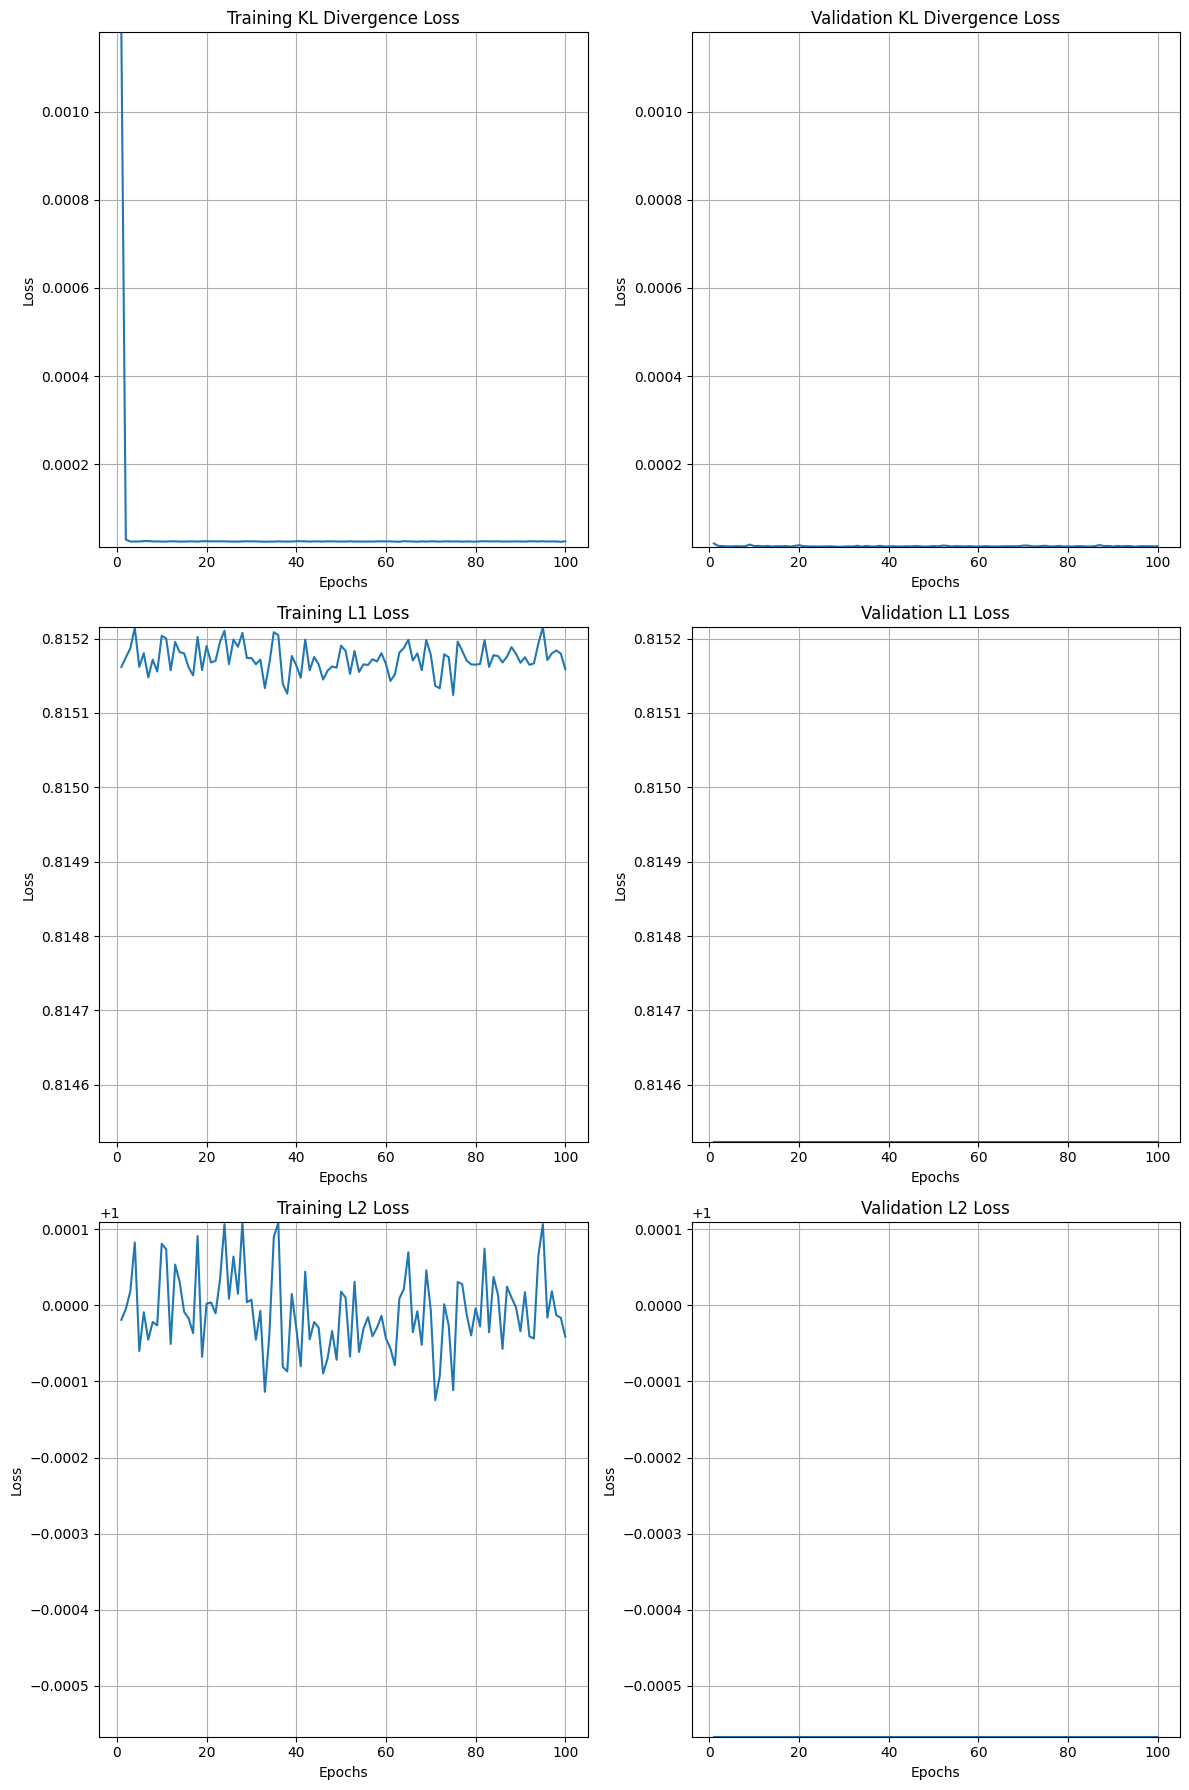

In [13]:
# * * * * * * * * * * * * * * * *
# Plot Losses
# * * * * * * * * * * * * * * * *
PlotLosses(losses, EPOCHS, model_dir)
SaveLossesToCSV(losses, os.path.join(model_dir, "losses.csv"))

In [14]:
# * * * * * * * * * * * * * * * *
# Best Validation Loss
# * * * * * * * * * * * * * * * *
PrintAndLog(log_filepath, "Best Validation Loss in Kelvins:\n")
PrintAndLog(
	log_filepath,
	f"\t{min(losses['val_l1_losses'])*x_data_std:.4f} K\n")

Best Validation Loss in Kelvins:
83.1718 K


In [15]:
# * * * * * * * * * * * * * * * *
# Sample
# * * * * * * * * * * * * * * * *
z_sample = SampleLatentSpace(
	vae,
	test_loader,
	scaler,
	DEVICE,
	model_dir
)

[Sampling]: 100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


z0: -0.0011
z1: -0.0005
z2: -0.0008
z3: 0.0003


Traversing Latent Dimension z3: 100%|██████████| 11/11 [00:00<00:00, 652.33it/s]


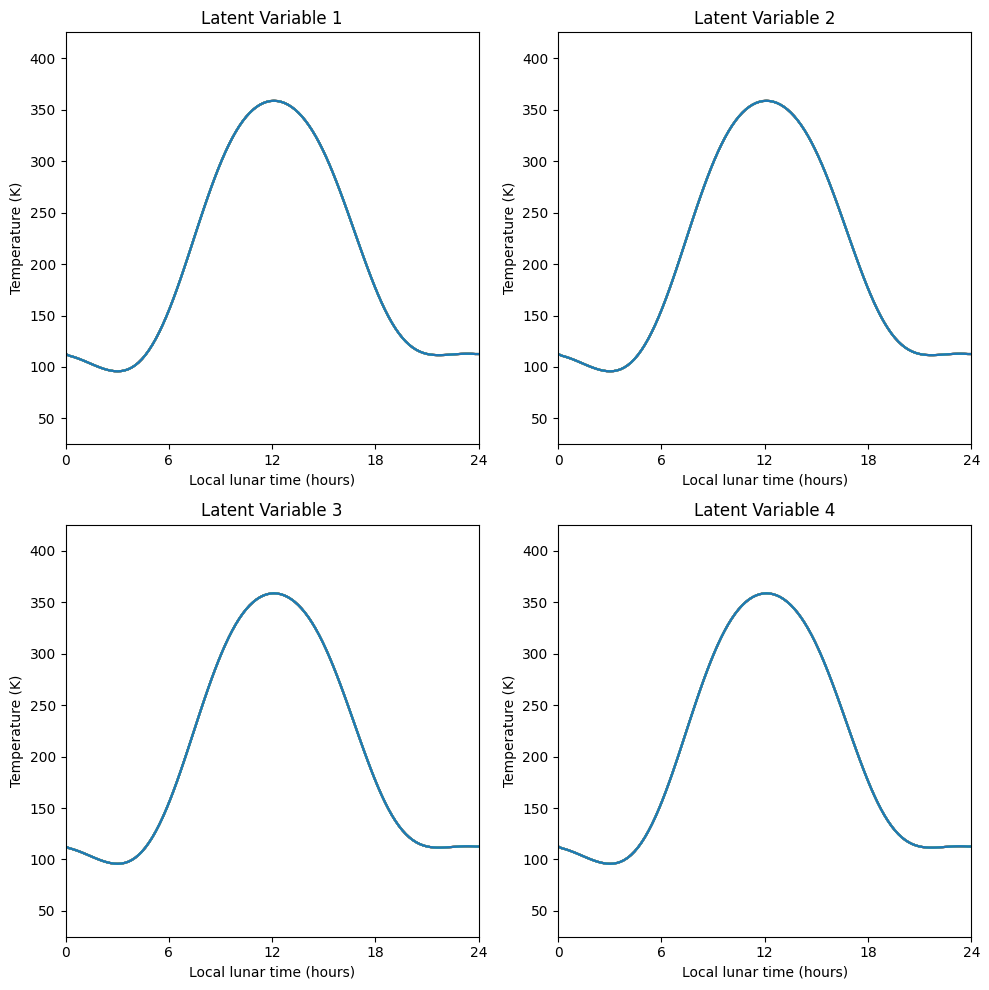

In [16]:
# * * * * * * * * * * * * * * * *
# Analyze Latent Space
# * * * * * * * * * * * * * * * *
mean_latent_vals = GetMeanLatentValues(z_sample, LATENT_DIM)
for i in range(LATENT_DIM):
	print(f"z{i}: {mean_latent_vals[i]:.4f}")

VisualizeLatentSpace(
	vae, LATENT_DIM, z_sample,
	scaler, DEVICE, model_dir)